# Koopman Seq2Seq model

[work in progress]

Here I develop a new ML architecture, combining Koopman kernel methods with a seq2seq architecture.

In [1]:
import os
import random
import time

import numpy as np
import torch
from absl import app
# from klearn_tcyclone.training_utils.args import FLAGS, ALL_FLAGS
from klearn_tcyclone.training_utils.training_utils import get_default_flag_values
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils import data

from klearn_tcyclone.climada.tc_tracks import TCTracks
from klearn_tcyclone.data_utils import (
    LinearScaler,
)
from klearn_tcyclone.KNF.modules.eval_metrics import RMSE_TCTracks
from klearn_tcyclone.KNF.modules.models import Koopman
from klearn_tcyclone.KNF.modules.train_utils import (
    eval_epoch_koopman,
    train_epoch_koopman,
)
from klearn_tcyclone.knf_data_utils import TCTrackDataset
from klearn_tcyclone.training_utils.training_utils import set_flags
from absl import app, flags

from klearn_tcyclone.training_utils.training_utils import extend_by_default_flag_values

from klearn_tcyclone.koopkernel_seq2seq import KoopmanKernelSeq2Seq, RBFKernel
from klearn_tcyclone.koopkernel_seq2seq import KoopKernelLoss, batch_tensor_context

from klearn_tcyclone.data_utils import (
    load_model,
    standardized_context_dataset_from_TCTracks,
)

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from matplotlib import pyplot as plt


from matplotlib import pyplot as plt
import copy
from matplotlib.axes._axes import Axes

from klearn_tcyclone.KNF.modules.models import Koopman
import torch



In [28]:
from klearn_tcyclone.koopkernel_seq2seq_utils import train_one_epoch
from klearn_tcyclone.koopkernel_seq2seq_utils import train_KKSeq2Seq
from klearn_tcyclone.koopkernel_seq2seq_utils import predict_koopman_seq2seq_model, plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq
from klearn_tcyclone.plot_utils import plot_TCTrackDataset_item_2D

## Import data

Set some specific parameters and load default values for all other parameters.

In [3]:
flag_params = {
    # "seed": 42,
    "year_range": [1980, 1988],
    # "batch_size": 16,
    "num_epochs": 20,
    "train_output_length": 1,
    "test_output_length": 1,
    "input_length": 13,
    "context_length": 14,
}
flag_params = extend_by_default_flag_values(flag_params)

assert flag_params["context_length"] == flag_params["input_length"] + flag_params["train_output_length"]

In [4]:
random.seed(flag_params["seed"])  # python random generator
np.random.seed(flag_params["seed"])  # numpy random generator

torch.manual_seed(flag_params["seed"])
torch.cuda.manual_seed_all(flag_params["seed"])

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    # "radius_max_wind",
    # "radius_oci",
    "central_pressure",
    "environmental_pressure",
]

# feature_list = [
#     "lon",
#     "lat",
#     "max_sustained_wind",
#     "radius_max_wind",
#     "radius_oci",
#     "central_pressure",
#     "environmental_pressure",
# ]

# these are not contained as flags
# encoder_hidden_dim = flag_params["hidden_dim"]
# decoder_hidden_dim = flag_params["hidden_dim"]
# encoder_num_layers = flag_params["num_layers"]
# decoder_num_layers = flag_params["num_layers"]

output_dim = flag_params["input_dim"]
num_feats = len(feature_list)
learning_rate = flag_params["learning_rate"]
# ---------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

scaler = LinearScaler()
eval_metric = RMSE_TCTracks

Device cuda


In [5]:
# Datasets
tc_tracks = TCTracks.from_ibtracs_netcdf(
    provider="official",
    year_range=flag_params["year_range"],
    basin="NA",
)

tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

2025-02-19 20:35:49,333 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/ecjb/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-02-19 20:37:32,730 - climada.hazard.tc_tracks - WARNING - 49 storm events are discarded because no valid wind/pressure values have been found: 1980199N31284, 1980200N25270, 1980204N23287, 1980226N15339, 1980238N16328, ...


/home/ecjb/packages/climada_python/climada/hazard/tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


In [6]:
len(tc_tracks_train), tc_tracks_train[5]

(73,
 <xarray.Dataset> Size: 8kB
 Dimensions:                 (time: 134)
 Coordinates:
   * time                    (time) datetime64[ns] 1kB 1986-08-13T12:00:00 ......
     lat                     (time) float32 536B 30.1 30.45 30.8 ... 56.2 56.2
     lon                     (time) float32 536B -84.0 -84.0 -84.0 ... 7.0 8.0
 Data variables:
     radius_max_wind         (time) float32 536B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     radius_oci              (time) float32 536B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     max_sustained_wind      (time) float32 536B 10.0 10.0 10.0 ... 15.0 15.0
     central_pressure        (time) float32 536B 1.009e+03 1.01e+03 ... 1.006e+03
     environmental_pressure  (time) float64 1kB 1.01e+03 1.01e+03 ... 1.01e+03
     time_step               (time) float64 1kB 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0
     basin                   (time) <U2 1kB 'NA' 'NA' 'NA' ... 'NA' 'NA' 'NA'
 Attributes:
     max_sustained_wind_unit:  kn
     central_pressure_unit:    mb
     orig_event

In [7]:
time_lag = 1
scaler = LinearScaler()
basin = "NA"

The idea is to feed the tensor_context_dataset into the model. Because for the kernels I need the lookback window and the shifted version of this.

In [8]:
tensor_context_train_standardized = standardized_context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=feature_list,
    scaler=scaler,
    context_length=flag_params["context_length"],
    time_lag=time_lag,
    fit=True,
    periodic_shift=True,
    basin=basin,
)

con_len set to context_length.


In [9]:
tensor_context_train_standardized.shape

(3301, 14, 5)

In [10]:
flag_params["context_length"]

14

In [11]:
flag_params["input_length"], flag_params["train_output_length"]

(13, 1)

In [12]:
train_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="train",
    jumps=flag_params["jumps"],
    scaler=scaler,
    fit=True,
)
valid_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="valid",
    jumps=flag_params["jumps"],
    scaler=scaler,
    fit=False,
)
test_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["test_output_length"],
    tc_tracks=tc_tracks_test,
    feature_list=feature_list,
    mode="test",
    # jumps=flag_params["jumps"], # jumps not used in test mode
    scaler=scaler,
    fit=False,
)
train_loader = data.DataLoader(
    train_set, batch_size=flag_params["batch_size"], shuffle=True, num_workers=1
)
valid_loader = data.DataLoader(
    valid_set, batch_size=flag_params["batch_size"], shuffle=True, num_workers=1
)
test_loader = data.DataLoader(
    test_set, batch_size=flag_params["batch_size"], shuffle=False, num_workers=1
)

if len(train_loader) == 0:
    raise Exception(
        "There are likely too few data points in the test set. Try to increase year_range."
    )

Check why we have nan values!!!

In [13]:
counter = 0
for inps, tgts in train_loader:
    if counter < 5:
        print(counter)
        print(inps.shape, type(inps))
        print(tgts.shape, type(inps))
        print(inps[0,:,0])
        print(tgts[0,:,0])
        print()
    
    counter += 1


0
torch.Size([32, 13, 5]) <class 'torch.Tensor'>
torch.Size([32, 1, 5]) <class 'torch.Tensor'>
tensor([-0.3270, -0.3238, -0.3222, -0.3143, -0.3064, -0.2969, -0.2874, -0.2795,
        -0.2573, -0.2352, -0.2177, -0.2003, -0.1742])
tensor([-0.1481])

1
torch.Size([32, 13, 5]) <class 'torch.Tensor'>
torch.Size([32, 1, 5]) <class 'torch.Tensor'>
tensor([-0.0808, -0.0768, -0.0752, -0.0736, -0.0744, -0.0752, -0.0776, -0.0800,
        -0.0863, -0.0926, -0.0982, -0.1037, -0.1093])
tensor([-0.1148])

2
torch.Size([32, 13, 5]) <class 'torch.Tensor'>
torch.Size([32, 1, 5]) <class 'torch.Tensor'>
tensor([0.6120, 0.6239, 0.6358, 0.6397, 0.6437, 0.6477, 0.6516, 0.6714, 0.6912,
        0.7189, 0.7466, 0.7625, 0.7783])
tensor([0.7862])

3
torch.Size([32, 13, 5]) <class 'torch.Tensor'>
torch.Size([32, 1, 5]) <class 'torch.Tensor'>
tensor([-0.1433, -0.1489, -0.1544, -0.1591, -0.1639, -0.1686, -0.1734, -0.1774,
        -0.1813, -0.1845, -0.1876, -0.1892, -0.1908])
tensor([-0.1916])

4
torch.Size([32, 13, 

In [14]:
tensor_context_train_standardized.data.shape

(3301, 14, 5)

In [15]:
flag_params["input_length"], flag_params["train_output_length"]

(13, 1)

In [16]:
flag_params["train_output_length"]

1

In [17]:
# tensor_context_inps, tensor_context_tgts = batch_tensor_context(
#     tensor_context_train_standardized,
#     batch_size=flag_params["batch_size"],
#     input_length=flag_params["input_length"],
#     output_length=flag_params["train_output_length"],
# )
# assert torch.all(tensor_context_inps[:,:,1:] == tensor_context_tgts[:,:,:-1])
# tensor_context_inps.shape, tensor_context_tgts.shape

In [18]:
m = nn.Dropout(p=0.2)
input = torch.randn(12, 4)
# output = input
output = m(input)

In [19]:
output

tensor([[ 0.4358,  0.8254, -0.2745, -0.4740],
        [ 0.0000,  0.9406, -0.8027, -1.0160],
        [ 0.2242,  2.3689,  0.6193,  0.3365],
        [ 0.0000, -1.7793,  0.7342, -1.6120],
        [ 1.9762,  1.6263,  1.5941, -0.2512],
        [-0.2007, -0.5019,  0.8697, -2.2576],
        [-1.4486,  0.4068, -0.0000, -3.5500],
        [-0.9811, -1.7620, -0.5095,  0.9942],
        [-0.4856, -1.1679, -0.6239, -0.0000],
        [ 1.2030,  0.3115, -0.6056, -2.6161],
        [ 0.1229, -0.0000,  0.3328, -0.7313],
        [-0.0000, -0.8527, -1.2359, -2.1273]])

### Single step model

In [21]:
flag_params["koopman_kernel_num_centers"] = 200
# flag_params["koopman_kernel_num_centers"] = 1000

In [22]:
rbf = RBFKernel(length_scale=1E-1)

#TODO some parameters don't play a role in model definition -> remove them
koopkernelmodel = KoopmanKernelSeq2Seq(
    kernel=rbf,
    input_dim = num_feats,
    input_length = 13,
    output_length = 1,
    output_dim = 1,
    num_steps = 1,
    num_nys_centers = flag_params["koopman_kernel_num_centers"],
    rng_seed = 42,
    # context_mode="last_context"
    # context_mode="no_context"
    context_mode="full_context"
)

koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)

torch.Size([200, 5]) torch.Size([200, 5])


#### Compare context modes

In [23]:
rbf = RBFKernel(length_scale=1E-1)

context_modes = [
    "no_context",
    "full_context",
    "last_context",
]
models = {}
train_losses = {}
for cm in context_modes:


    #TODO some parameters don't play a role in model definition -> remove them
    koopkernelmodel = KoopmanKernelSeq2Seq(
        kernel=rbf,
        input_dim = num_feats,
        input_length = flag_params["input_length"],
        output_length = flag_params["train_output_length"],
        output_dim = 1,
        num_steps = 1,
        num_nys_centers = flag_params["koopman_kernel_num_centers"],
        rng_seed = 42,
        context_mode=cm,
    )

    koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)


    m, tl = train_KKSeq2Seq(
        model=koopkernelmodel,
        tensor_context=tensor_context_train_standardized,
        num_epochs=flag_params["num_epochs"],
        batch_size=flag_params["batch_size"],
        input_length=flag_params["input_length"],
        output_length=flag_params["train_output_length"],
        decay_rate=flag_params["decay_rate"],
        learning_rate=learning_rate,
    )
    models[cm] = m
    train_losses[cm] = tl

torch.Size([200, 5]) torch.Size([200, 5])
range(0, 103)
  batch 10 loss: 0.4011105179786682
  batch 20 loss: 0.38517900705337527
  batch 30 loss: 0.3620048135519028
  batch 40 loss: 0.35315867364406583
  batch 50 loss: 0.3315192639827728
  batch 60 loss: 0.3220981627702713
  batch 70 loss: 0.2985411524772644
  batch 80 loss: 0.29460883140563965
  batch 90 loss: 0.2856984525918961
  batch 100 loss: 0.27652729749679567
{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'initial_lr': 0.001, 'params': [0]}
range(0, 103)
  batch 10 loss: 0.2636053338646889
  batch 20 loss: 0.2517401561141014
  batch 30 loss: 0.24831653088331224
  batch 40 loss: 0.24913471937179565
  batch 50 loss: 0.23190155625343323
  batch 60 loss: 0.23722792267799378
  batch 70 loss: 0.22023593932390212
  batch 80 loss: 0.22373368144035338
  batch 90 loss: 0.22091227173805236
  batch 100 l

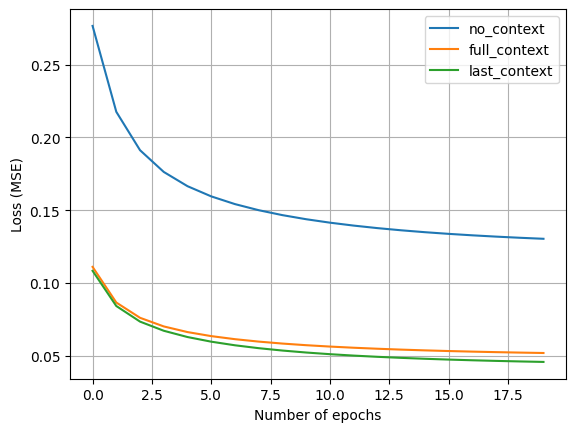

In [24]:
fig, ax = plt.subplots()

for idx, cm in enumerate(context_modes):
    ax.plot(range(flag_params["num_epochs"]), train_losses[cm], color = f"C{idx}", label = cm)
# ax.set_yscale("log")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss (MSE)")
ax.legend()
ax.grid()

# save_path = os.path.join(
#     "../plots/", "koopman_seq2seq/"
# )
# os.makedirs(save_path, exist_ok=True)
# fig.savefig(os.path.join(save_path, "context_mode_comparison.png"), bbox_inches='tight')

#### Plot predictions

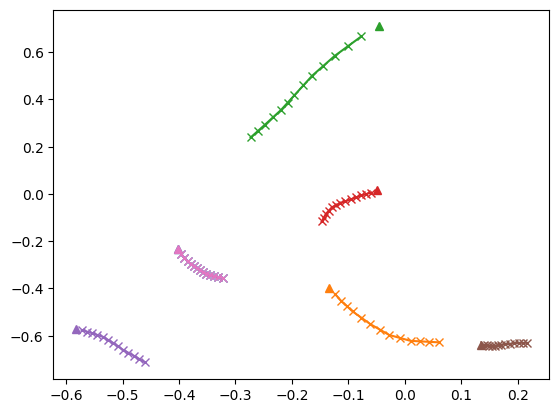

In [29]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 7)):
    plot_TCTrackDataset_item_2D(train_set, idx, ax, color=f"C{i}")

torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([3, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([3, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([3, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([3, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([3, 5])


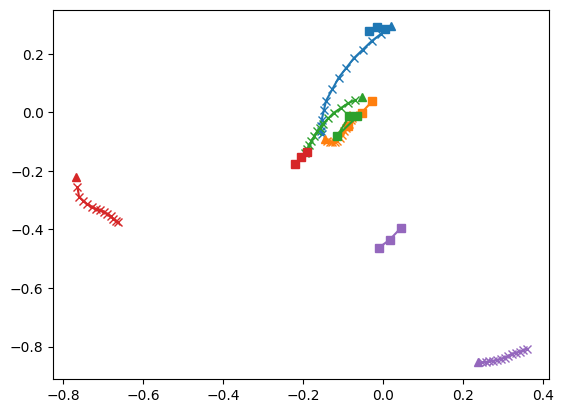

In [30]:
prediction_steps = 3

fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 5)):

    plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq(
        train_set,
        idx,
        prediction_steps=prediction_steps,
        model=models["full_context"],
        ax=ax,
        color=f"C{i}"
    )

# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_xlim(-6,-5)
# ax.set_ylim(-9.25,-9)

### Multi step model

In [80]:
flag_params["input_length"] = 13
flag_params["train_output_length"] = 5
flag_params["context_length"] = flag_params["input_length"] + flag_params["train_output_length"]
flag_params["num_epochs"] = 50
# flag_params["koopman_kernel_num_centers"] = 50
flag_params["koopman_kernel_num_centers"] = 1000

In [81]:
tensor_context_train_standardized = standardized_context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=feature_list,
    scaler=scaler,
    context_length=flag_params["context_length"],
    time_lag=time_lag,
    fit=True,
    periodic_shift=True,
    basin=basin,
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
)

intput_length and output_length are not None.


In [82]:
tensor_context_train_standardized.shape

(3015, 18, 5)

In [83]:
# tensor_context_inps, tensor_context_tgts = batch_tensor_context(
#     tensor_context_train_standardized,
#     batch_size=flag_params["batch_size"],
#     input_length=flag_params["input_length"],
#     output_length=flag_params["train_output_length"],
# )

# for idx in range(flag_params["train_output_length"]):
#     if flag_params["train_output_length"] == 1:
#         assert torch.all(tensor_context_inps[:,:,idx+1:] == tensor_context_tgts[:,:,:-idx-1])
#     else:
#         assert torch.all(tensor_context_inps[:,:,idx+1:] == tensor_context_tgts[:,:,:-idx-1,idx])
# tensor_context_inps.shape, tensor_context_tgts.shape

In [84]:
# rbf = RBFKernel(length_scale=1E-1)

# #TODO some parameters don't play a role in model definition -> remove them
# koopkernelmodel = KoopmanKernelSeq2Seq(
#     kernel=rbf,
#     input_dim = num_feats,
#     input_length = flag_params["input_length"],
#     output_length = flag_params["train_output_length"],
#     output_dim = 1,
#     num_steps = 1,
#     num_nys_centers = flag_params["koopman_kernel_num_centers"],
#     rng_seed = 42,
#     # context_mode="last_context"
#     context_mode="no_context"
#     # context_mode="full_context"
# )

# koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)

#### Compare context modes

TODO: Something seems not to work with train_KKSeq2Seq(). For no_context and output_length > 1 an error should be raised!

In [85]:
flag_params["train_output_length"]

5

In [86]:
# context_modes = [
#     "no_context",
#     "full_context",
#     "last_context",
# ]
# models = {}
# train_losses = {}
# for cm in context_modes:
#     m, tl = train_KKSeq2Seq(flag_params["num_epochs"], cm)
#     models[cm] = m
#     train_losses[cm] = tl


rbf = RBFKernel(length_scale=1E-1)

context_mode = "last_context"
# context_mode = "full_context"
# context_mode = "no_context"

koopkernelmodel = KoopmanKernelSeq2Seq(
    kernel=rbf,
    input_dim = num_feats,
    input_length = flag_params["input_length"],
    output_length = flag_params["train_output_length"],
    output_dim = 1,
    num_steps = 1,
    num_nys_centers = flag_params["koopman_kernel_num_centers"],
    rng_seed = 42,
    context_mode=context_mode,
)
koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)


model, train_loss = train_KKSeq2Seq(
    model=koopkernelmodel,
    tensor_context=tensor_context_train_standardized,
    num_epochs=flag_params["num_epochs"],
    batch_size=flag_params["batch_size"],
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    decay_rate=flag_params["decay_rate"],
    learning_rate=learning_rate,
)



torch.Size([1000, 5]) torch.Size([1000, 5])
range(0, 94)
  batch 10 loss: 0.4492741316556931
  batch 20 loss: 0.2319808378815651
  batch 30 loss: 0.11231947094202041
  batch 40 loss: 0.07032168060541152
  batch 50 loss: 0.0663390163332224
  batch 60 loss: 0.052049097046256064
  batch 70 loss: 0.055054842680692676
  batch 80 loss: 0.0369167847558856
  batch 90 loss: 0.03742564171552658
{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'initial_lr': 0.001, 'params': [0]}
range(0, 94)
  batch 10 loss: 0.03486640602350235
  batch 20 loss: 0.03213535193353891
  batch 30 loss: 0.02332946062088013
  batch 40 loss: 0.021954132243990898
  batch 50 loss: 0.027205750904977323
  batch 60 loss: 0.025441078934818506
  batch 70 loss: 0.031246060132980348
  batch 80 loss: 0.022924530878663064
  batch 90 loss: 0.028894935548305512
{'lr': 0.0009000000000000001, 'betas': 

In [87]:
train_loss

[0.03742564171552658,
 0.028894935548305512,
 0.026346487738192082,
 0.02542712166905403,
 0.024877582490444184,
 0.0182928285561502,
 0.012673718249425292,
 0.010342279309406876,
 0.008692035917192698,
 0.008351310202851892,
 0.009006814262829722,
 0.012452550837770105,
 0.006446364079602062,
 0.006057468452490866,
 0.0059493490727618335,
 0.005976478941738606,
 0.008881823113188147,
 0.005688745249062777,
 0.006159429065883159,
 0.005144059960730374,
 0.004538535559549928,
 0.0043784511974081395,
 0.004299299069680273,
 0.00417413174873218,
 0.004032243485562503,
 0.003929367510136217,
 0.0038489003316499295,
 0.003754794003907591,
 0.00368600282818079,
 0.003625546267721802,
 0.003566568612586707,
 0.0035117162740789356,
 0.003460326394997537,
 0.003413498983718455,
 0.00337375063681975,
 0.0033386012190021576,
 0.0033034726278856398,
 0.0032682946417480706,
 0.0032346159452572463,
 0.0032045458909124138,
 0.003179080761037767,
 0.0031571053550578654,
 0.003137594787403941,
 0.00311

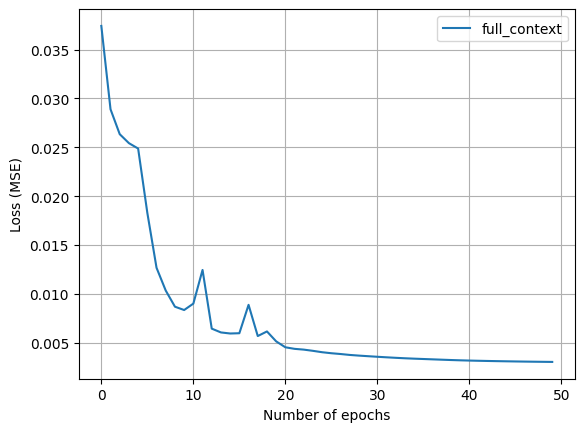

In [88]:
fig, ax = plt.subplots()

ax.plot(range(flag_params["num_epochs"]), train_loss, color = f"C{0}", label = "full_context")
# ax.set_yscale("log")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss (MSE)")
ax.legend()
ax.grid()

# save_path = os.path.join(
#     "../plots/", "koopman_seq2seq/"
# )
# os.makedirs(save_path, exist_ok=True)
# fig.savefig(os.path.join(save_path, "context_mode_comparison.png"), bbox_inches='tight')

#### Plot predictions

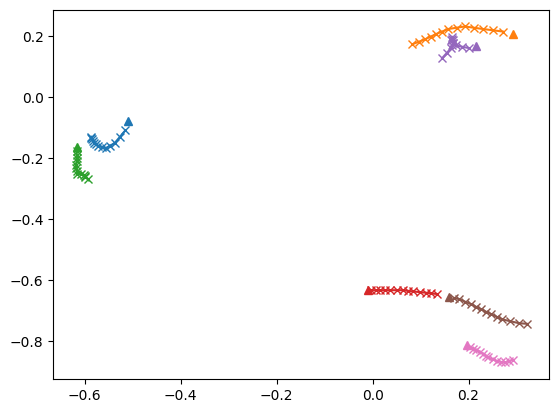

In [71]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 7)):
    plot_TCTrackDataset_item_2D(train_set, idx, ax, color=f"C{i}")

torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])


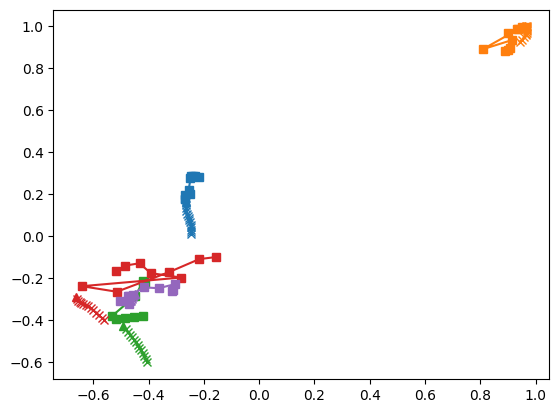

In [78]:
prediction_steps = 10

fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 5)):

    plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq(
        train_set,
        idx,
        prediction_steps=prediction_steps,
        model=model,
        ax=ax,
        color=f"C{i}"
    )

# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_xlim(-6,-5)
# ax.set_ylim(-9.25,-9)